# Temporal Difference Based Prediction and Control (SARSA, Q-Learning)

## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import gymnasium as gym
from collections import defaultdict
import sys
import time
from IPython.display import display, clear_output
from utils import *

## Config

In [2]:
CONFIG = {
    'env':{
        'desc': None,
        'lake_size': 4,
        'is_slippery': True,
    },
    'TDLambda':{
        'num_episodes': 5000,
        'gamma': 0.99,
        'alpha': 0.1,
        'lambda_': 0.3,
        'replace_traces': False,
    },
    'SARSALambda': {
        'num_episodes': 5000,
        'gamma': 0.99,
        'alpha': 0.1,
        'lambda_': 0.0,
        'epsilon': 1.0,
        'epsilon_decay': 0.999,
        'replace_traces': False,
    },
    'QLearning':{
        'num_episodes': 5000,
        'gamma': 0.99,
        'alpha': 0.1,       
        'epsilon': 1.0,
        'epsilon_decay': 0.999,
    },
    'animation':{
        'FPS': 15,
        'do_truncate': False,
    },
    'print_policy_thresh': 1e-6,
}

## Creating the env

In [3]:
lake_size = CONFIG['env']['lake_size']
lake_shape = (lake_size,lake_size)
env = gym.make('FrozenLake-v1',
               desc= CONFIG['env']['desc'], 
               map_name= "8x8" if lake_size == 8 else "4x4",
               is_slippery= CONFIG['env']['is_slippery'], 
               render_mode= "rgb_array")

## Helper functions

In [4]:
def value_fn_heatmap(V):
    V = V.reshape(lake_shape)

    plt.figure(figsize=(6, 5))
    heatmap = plt.imshow(V, cmap='viridis', origin='upper') 
    plt.axis('off')
    plt.colorbar(heatmap, label='State Value')
    plt.title('Value Function Heatmap')
    plt.show()

In [5]:
def print_policy(policy: np.ndarray, V: np.ndarray, shape: tuple([int,int]) = (4, 4), threshold: float = 1e-5):
    '''
    Visualizes a given deterministic policy using arrows

    Args:
        policy (np.ndarray): Array of size [S x A] representing the policy
        V (np.ndarray): Array of length S representing the value function
        shape (tuple[int,int]): Shape of the environment
        threshold (float): The threshold value under which states are classified as terminal based on V
    '''
    if shape[0] == 4:
        print(f"== Policy ==")
    else:
        print(f"======= Policy ========")
    action_symbols = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    for i in range(shape[0]):
        row = ""
        for j in range(shape[1]):
            s = i * shape[1] + j
            if V[s] < threshold:
                row += " . "   
            else:
                row += f" {action_symbols[policy[s]]} "
        print(row)

## Temporal Difference Evaluation

In [6]:
def TDLambda(env, policy, num_episodes = 100, gamma = 1.0, alpha = 0.1, lambda_ = 0.0, replace_traces = False):

    nS = env.observation_space.n
    nA = env.action_space.n

    V = np.zeros(nS)
    E = np.zeros(nS)

    for e in range(1, num_episodes + 1):

        if e % 10 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes}', end = '')
            sys.stdout.flush()

        s,_ = env.reset()
        while True:
            
            a = np.random.choice(list(range(nA)), p = policy[s])
            s_n, r, terminated, truncated, _ = env.step(a)

            delta = r + gamma*V[s_n] - V[s] 

            if replace_traces: E[s] = 1
            else: E[s] += 1
            
            for s_ in range(nS):
                V[s_] += alpha*delta*E[s_]
                E[s_] *= gamma * lambda_
                
            if terminated or truncated:
                break
            s = s_n

    return V


Episode : 5000/5000

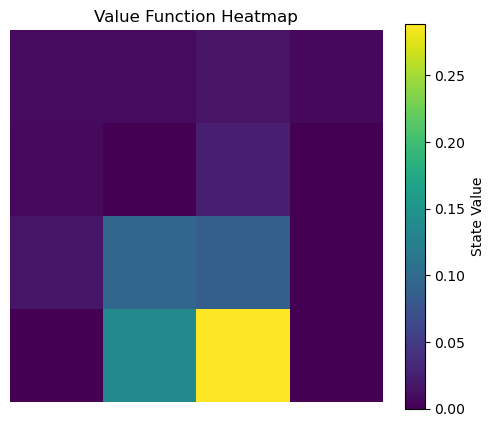

In [7]:
random_policy = np.ones((env.observation_space.n,env.action_space.n))/env.action_space.n

V = TDLambda(env, random_policy, **CONFIG['TDLambda'])

value_fn_heatmap(V)

## SARSA

In [8]:
def SARSALambda(env, num_episodes = 100, gamma = 1.0, alpha = 0.1, lambda_ = 0.0,
                epsilon = 0.0, epsilon_decay = 1.0, replace_traces = False):


    def get_eps_greedy_policy(Q, epsilon):
        eps_greedy_policy = np.ones((nS,nA))*epsilon/nA
        for s in range(nS):
            best_a = np.argmax(Q[s])
            eps_greedy_policy[s][best_a] += 1 - epsilon
        return eps_greedy_policy
        
    
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA))
    E = np.zeros((nS, nA))

    policy = get_eps_greedy_policy(Q, epsilon)
    
    for e in range(1, num_episodes + 1):

        if e % 10 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes}', end = '')
            sys.stdout.flush()

        s,_ = env.reset()
        a = np.random.choice(list(range(nA)), p = policy[s])
        while True:
            
            s_n, r, terminated, truncated, _ = env.step(a)
            a_n = np.random.choice(list(range(nA)), p = policy[s_n])

            delta = r + gamma*Q[s_n, a_n] - Q[s, a] 

            if replace_traces: E[s, a] = 1
            else: E[s, a] += 1
            
            for s_ in range(nS):
                for a_ in range(nA):
                    Q[s_, a_] += alpha*delta*E[s_, a_]
                    E[s_, a_] *= gamma * lambda_
                
            if terminated or truncated:
                break
                
            s = s_n
            a = a_n

        epsilon *= epsilon_decay
        policy = get_eps_greedy_policy(Q, epsilon)

    return Q, policy

Episode : 5000/5000


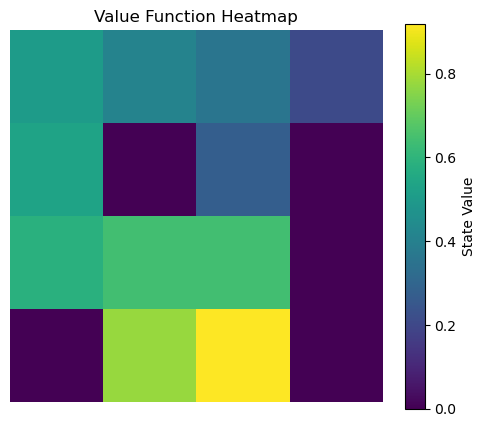

In [9]:
Q_sarsa, sarsa_policy = SARSALambda(env, **CONFIG['SARSALambda'])

print()
V_sarsa = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    V_sarsa[s] = np.max(Q_sarsa[s])

value_fn_heatmap(V_sarsa)

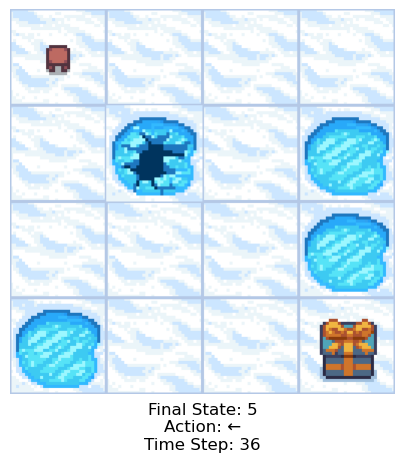

== Policy ==
 ←  ↑  ←  ↑ 
 ←  .  ←  . 
 ↑  ↓  ←  . 
 .  →  ↓  . 


In [12]:
plots.animate_policy(env, lambda s: sarsa_policy[int(s)], **CONFIG['animation'])

print_policy(policy = np.argmax(sarsa_policy, axis=1), V = V_sarsa,
             shape = lake_shape, threshold = CONFIG['print_policy_thresh'])

## Q-Learning

In [13]:
def QLearning(env, num_episodes = 100, gamma = 1.0, alpha = 0.1, epsilon = 0.0, epsilon_decay = 1.0):

    def get_eps_greedy_policy(Q, epsilon):
        eps_greedy_policy = np.ones((nS,nA))*epsilon/nA
        for s in range(nS):
            best_a = np.argmax(Q[s])
            eps_greedy_policy[s][best_a] += 1 - epsilon
        return eps_greedy_policy
        
    
    nS = env.observation_space.n
    nA = env.action_space.n

    Q = np.zeros((nS, nA))

    policy = get_eps_greedy_policy(Q, epsilon)
    
    for e in range(1, num_episodes + 1):

        if e % 10 == 0 or e == num_episodes:
            print(f'\rEpisode : {e}/{num_episodes}', end = '')
            sys.stdout.flush()

        s,_ = env.reset()
        while True:
            a = np.random.choice(list(range(nA)), p = policy[s])
            s_n, r, terminated, truncated, _ = env.step(a)
            a_n = np.argmax(Q[s_n]) 

            Q[s, a] += alpha * (r + gamma * Q[s_n, a_n] - Q[s, a])
            
            if terminated or truncated:
                break
                
            s = s_n

        epsilon *= epsilon_decay
        policy = get_eps_greedy_policy(Q, epsilon)

    # Get the greedy policy wrt Q
    policy = get_eps_greedy_policy(Q, 0.0)
    return Q, policy

Episode : 5000/5000


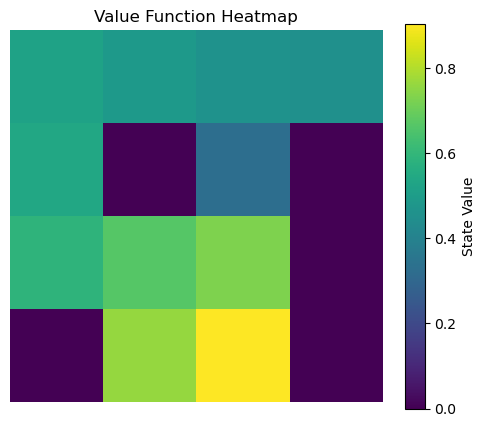

In [14]:
Q_ql, ql_policy = QLearning(env,**CONFIG['QLearning'])

print()
V_ql = np.zeros(env.observation_space.n)
for s in range(env.observation_space.n):
    V_ql[s] = np.max(Q_ql[s])

value_fn_heatmap(V_ql)

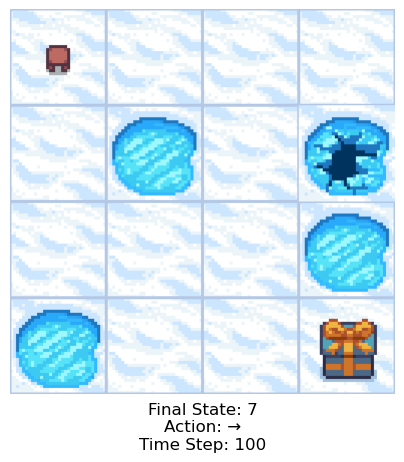

== Policy ==
 ←  ↑  ↑  ↑ 
 ←  .  →  . 
 ↑  ↓  ←  . 
 .  →  ↓  . 


In [15]:
plots.animate_policy(env,lambda s: ql_policy[int(s)], **CONFIG['animation'])

print_policy(policy = np.argmax(ql_policy, axis=1), V = V_ql,
             shape = lake_shape, threshold = CONFIG['print_policy_thresh'])